# Feature extraction from ambient seismic field


This tutorial will give examples on how to extract features from ambient field data. We will ue

In [44]:
import numpy as np
import pandas as pd

# import warnings
# warnings.simplefilter("ignore")

# seismic packages
import obspy
from obspy.clients.fdsn.client import Client 
from obspy.geodetics.base import gps2dist_azimuth
import obspy.signal
import obspy.signal.filter
client=Client("IRIS")


# plotting packages
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
%matplotlib inline

matplotlib.rc('font', size=12) 
matplotlib.rc('font', size=12) 
plt.rcParams['figure.figsize'] = (11, 8)

# scipy for seismic data processing
import scipy as sc
from scipy import signal


# feature extraction packages
import tsfel
import seis_feature     # this is a compilation


First, we will download noise data using obspy. Let's pick an interesting station for noise.

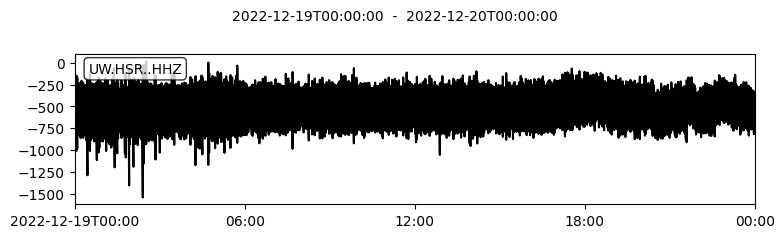

100.0


In [2]:
t0 = obspy.UTCDateTime("2022-12-19")
tr=client.get_waveforms(network="UW",station="HSR",channel="HHZ",location="*",starttime=t0,endtime=t0+86400,attach_response=True);
# tr.remove_response()
tr.plot() 
fs=tr[0].stats.sampling_rate
print(fs)
     

The data looks quite noisy with no apparent change in the amplitudes.  We will proceed with increasing complexity in the features.  
## 1. Fourier Transform

In [3]:
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len
tr2 = tr.copy()
npts = tr2[0].stats.npts
## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(int(tr2[0].data.shape[0])) # this will be an even number
freqVec = fftfreq(Nfft, d=tr2[0].stats.delta)[:Nfft//2]
tr2.detrend('demean')
tr2.taper(max_percentage=0.05)
Zhat = fft(tr2[0].data,n=Nfft)#/np.sqrt(Z[0].stats.npts)

plotting

Text(0, 0.5, 'Velocity spectrum (m/s)')

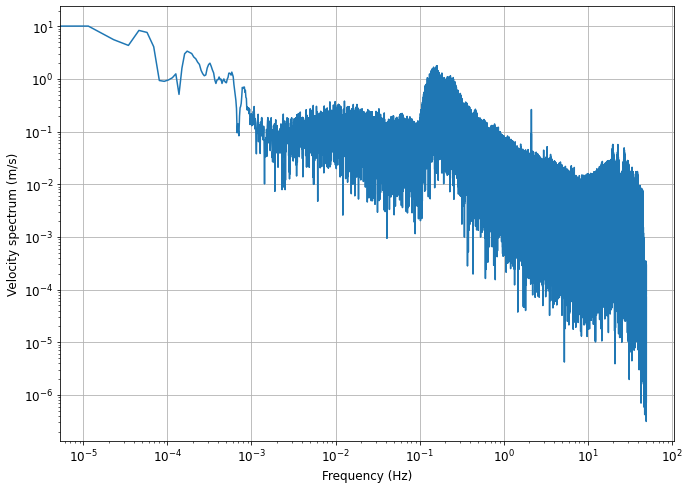

In [4]:
fig,ax=plt.subplots()
ax.plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
ax.grid(True)
ax.set_xscale('log');ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)');ax.set_ylabel('Velocity spectrum (m/s)')

## 2. Spectrogram

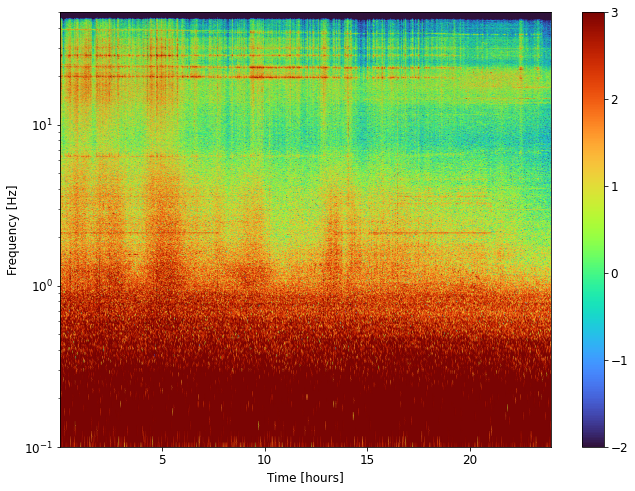

In [5]:
f, t, Sxx = signal.spectrogram(tr[0].data, fs = tr[0].stats.sampling_rate,nperseg=40*256)
plt.pcolormesh(t/3600, f,np.log10(Sxx),vmin=-2,vmax=3,cmap="turbo", shading="gouraud")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [hours]')
plt.yscale('log')
plt.ylim([0.1,50])
plt.colorbar(label="")
plt.show()

## 3. Features used in event detections

1. STA/LTA to detect earthquakes (at almost all seismic networks)
2. Kurtosis to detect earthquakes (at several seismic networks)

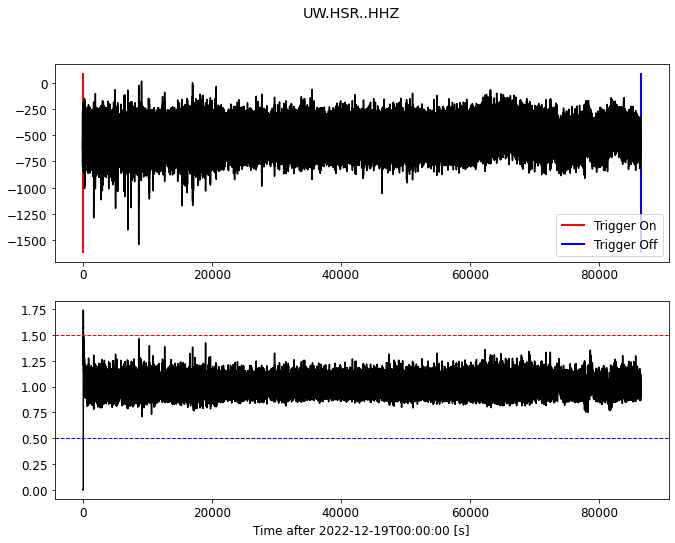

In [28]:
from obspy.signal.trigger import classic_sta_lta, plot_trigger, recursive_sta_lta

# short time scale:
sta = 5 # seconds
lta = 100 # seconds
cft = recursive_sta_lta(tr[0].data, int(sta * fs), int(lta * fs))
plot_trigger(tr[0], cft, 1.5, 0.5)

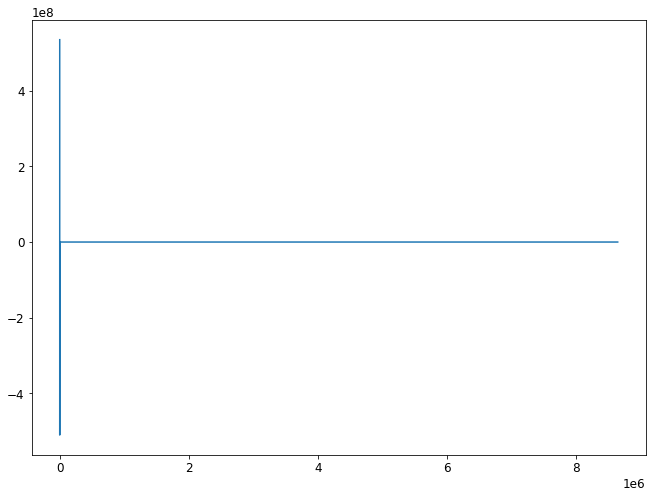

In [29]:
from obspy.realtime.signal import kurtosis
z=kurtosis(tr[0])
plt.plot(z)
plt.show()

## extract features using tsfel

TSFEL is an open-source package

In [31]:
cfg = tsfel.get_features_by_domain('temporal')
df = tsfel.time_series_features_extractor(cfg, tr[0].data[:100*100], fs= tr[0].stats.sampling_rate, window_size=len(tr[0].data[:100*100])) 

*** Feature extraction started ***



*** Feature extraction finished ***


In [32]:
df.head()

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_Entropy,0_Mean absolute diff,0_Mean diff,0_Median absolute diff,0_Median diff,0_Negative turning points,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate
0,2.870842e+09,52551.015,2.870842e+09,49.435118,0.653571,22.086109,0.010301,17.0,0.0,2496.0,346.0,665.0,2490.0,221588.036208,0.000472,220839.0,2.871129e+07,0.0


Now we will sweep through the data with a 10-min window length and add features to the data frame. We will reshape the data into a numpy array.

144 60000 8640000


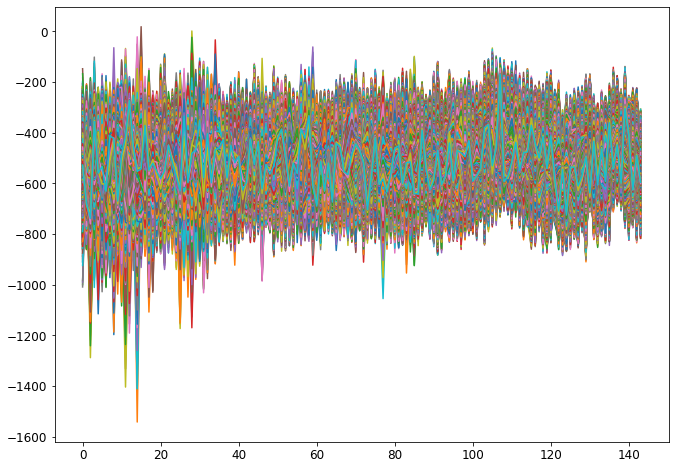

In [33]:
fs = tr[0].stats.sampling_rate
wlen = int(10 * 60 * fs)
step =  wlen
nwindow = int(np.floor(len(tr[0].data)/wlen))
nmax = int(wlen*np.floor(len(tr[0].data)/wlen))
print(nwindow,wlen,nmax)

data = np.reshape(tr[0].data[:nmax],(nwindow,wlen))
plt.plot(data);
# plt.pcolormesh(data,vmin=-0.002,vmax=0.001)


Now we will sweep through the data

In [13]:
cfg = tsfel.get_features_by_domain('temporal')
df=[]
for i in range(nwindow):
    if df is None:
        df=tsfel.time_series_features_extractor(cfg, data[i,:], fs= fs, window_size=wlen)
    else:
        df.append(tsfel.time_series_features_extractor(cfg, data[i,:], fs= fs, window_size=wlen))
df.head() 

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***


Process ForkPoolWorker-1622:
Process ForkPoolWorker-1624:
Process ForkPoolWorker-1618:
Process ForkPoolWorker-1615:
Process ForkPoolWorker-1613:
Process ForkPoolWorker-1619:
Process ForkPoolWorker-1617:
Process ForkPoolWorker-1604:
Process ForkPoolWorker-1621:
Process ForkPoolWorker-1594:
Process ForkPoolWorker-1629:
Process ForkPoolWorker-1625:
Process ForkPoolWorker-1586:
Process ForkPoolWorker-1626:
Process ForkPoolWorker-1608:
Process ForkPoolWorker-1631:
Process ForkPoolWorker-1605:
Process ForkPoolWorker-1607:
Process ForkPoolWorker-1609:
Process ForkPoolWorker-1595:
Traceback (most recent call last):
Process ForkPoolWorker-1587:
Process ForkPoolWorker-1597:
Process ForkPoolWorker-1630:
Traceback (most recent call last):
Process ForkPoolWorker-1623:
Process ForkPoolWorker-1591:
Traceback (most recent call last):
Process ForkPoolWorker-1628:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-1589:
Process ForkPoolWorker-1600:
Traceback (mo

  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/

  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/jupyter_sh

  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/pyth

KeyboardInterrupt
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
KeyboardInterrupt
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessin

In [ ]:
print(df)

Now we will calculate other features that have been useful in volcano seismology. We will follow Manuela's work on how to calculate RSAM/DSAR
# Workflow RSAM & DSAR

**The first step is to calculate the data stream. There are several sub-steps:**
1. After removing the instrument response to the seismic signals, apply a bandpass filter to each 24 hours of data, between 2-4.5, 4-8 and 8-16 Hz (corresponding to the RSAM, MF and HF bands).
2. Compute the absolute values of each signal.
3. Subdivide the signals into 10 minutes intervals. For each interval, compute the average value as the RSAM, MF and HF datapoints assigned to that interval.
4. Removing outliers associated with regional earthquakes is optional. We procced as follow: from (2), subdivide the signals into 10 minutes intervals. 
    1. Calculated the mean and standard deviation (mu and sigma) for each interval. 
    2. Apply z-score normalization in log-space to the interval using mu and sigma. 
    3. Check if any value in the interval exceeds a threshold of 3.2 standard deviations above the mean. 
    4. If yes, exclude data points from a 150s mask starting 15s before the outlier located. 
    5. Calculate the average value in the interval excluding points inside the mask: this the RSAM, MF and HF value for the interval.
**To calculate the DSAR, procced as follow:**
1. Integrate the bandpass filtered MF and HF data with time.
2. Take the absolute value and compute averages on 10-minute intervals.
3. Compute the ratio between integrated MF and HF.
**For computing the DSAR median feature proposed as a precursor in this paper follow:**
1. Every 10 minutes in the DSAR data stream, take a 48 hours window (looking backwards).
2. For each window, compute the median.
3. Construct the feature time series with point every 10 minutes corresponding the medians computed from the 48 hours windows.


In [7]:
tr.detrend('demean')
tr.taper(0.05, type='hann')
tr.merge(fill_value=0)
pre_filt = [1e-3, 5e-2, 45, 50]
water_level = 60
tr[0].remove_response(zero_mean=True,taper=True, taper_fraction=0.05,
                            pre_filt=pre_filt, output="VEL", water_level=water_level,
                            plot=False)


UW.HSR..HHZ | 2022-12-19T00:00:00.000000Z - 2022-12-20T00:00:00.000000Z | 100.0 Hz, 8640001 samples

In [21]:
fs = tr[0].stats.sampling_rate
wlen = int(10 * 60 * fs)
nmax = int(wlen*np.floor(len(tr[0].data)/wlen))
data = tr[0].data

In [22]:
def create_df(datas, ti, freqs_names, df):
    datas = np.array(datas)
    time = [(ti+j*600).datetime for j in range(datas.shape[1])]
    df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
    df = pd.concat([df, df_tr])
    return(df)

In [45]:
freqs = [[2, 5], [4.5, 8], [8,16]]
freqs_names = ['rsam','mf','hf','dsar','ndsar']
df = pd.DataFrame(columns=freqs_names)
datas=[]
for freq, frequ_name in zip(freqs, freqs_names[:3]):
    datas = seis_feature.RSAM(tr[0], fs, datas, freqs[0], nmax, wlen) # get RSAM for different frequency bands

datas, dsar = seis_feature.DSAR(data, fs, datas, freqs_names, freqs, nmax,wlen)
datas, ndsar = seis_feature.nDSAR(datas, dsar)
df = create_df(datas, tr[0].stats.starttime, freqs_names, df)
df

TypeError: nDSAR() takes 1 positional argument but 2 were given

In [ ]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))
# ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
#            label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))
ax.plot(df['rsam'], label='RSAM')
ax.plot(df['mf'], label='MF')
ax.plot(df['hf'], label='HF')
ax.plot(np.nan, label='DSAR')

ax2 = ax.twinx()
ax2.plot(df['dsar'], label='DSAR', color='C3')
ax2.set_ylim(0,6)

ax3 = ax.twinx()
ax3.plot(df['ndsar'], label='nDSAR', color='C4')

#ax.legend(ncol=4)